In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common import settings
from envs.fast_trading_env import FastTradingEnv
from policy.resnet_trading_model import ResnetTradingModel

In [101]:
def evaluation(model_name, stock_name, days=30):
    env = FastTradingEnv(name=stock_name, days=days)
    model = ResnetTradingModel(
        name='test',
        model_dir=settings.MODEL_DATA_DIR,
        input_shape=(settings.EPISODE_LENGTH, settings.FEATURE_NUM),
        load_model=True,
        specific_model_name=model_name
    )
    eval_history = []
    done = False
    last_obs = env.observations()
    while not done:
        p, v = model.predict(last_obs)
        action = np.argmax(p)
        obs, reward, done, _ = env.step(action)
        eval_history.append({
            'action_values': p,
            'predict_reward': v,
            'real_reward': reward,
            'pre_obs': last_obs,
            'post_obs': obs,
            'action': action,
        })
        last_obs = obs
    return eval_history

In [102]:
def show_plot(eval_history):
    # prepare data
    obs = pd.DataFrame(eval_history[-1]['post_obs'])
    obs.columns = ['open', 'high', 'low', 'close', 'volume']
    actions = [item['action'] for item in eval_history]
    signals = []
    for a1, a2 in zip(actions+[0], [0]+actions):
        if a1 == 1 and a2 == 0:
            # sell
            signals.append(2)
        elif a1 == 0 and a2 == 1:
            # buy
            signals.append(1)
        else:
            signals.append(0)
    signals = signals[:-1]
    buy_signals = [idx for idx, a in enumerate(signals) if a == 1]
    sell_signals = [idx for idx, a in enumerate(signals) if a == 2]
    print signals
    
    # draw figure
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    axs[0].set_ylabel('Volume')
    axs[0].plot(
        buy_signals, obs['volume'][buy_signals], 'b^',
        sell_signals, obs['volume'][sell_signals], 'rv',
    )
    axs[0].bar(obs['volume'].index, obs['volume'])
    
    axs[1].set_ylabel('Close Price')
    axs[1].plot(
        buy_signals, obs['close'][buy_signals], 'b^',
        sell_signals, obs['close'][sell_signals], 'rv',
        obs['close'].index, obs['close'], 'k-',
    )
    
    plt.show()

[2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


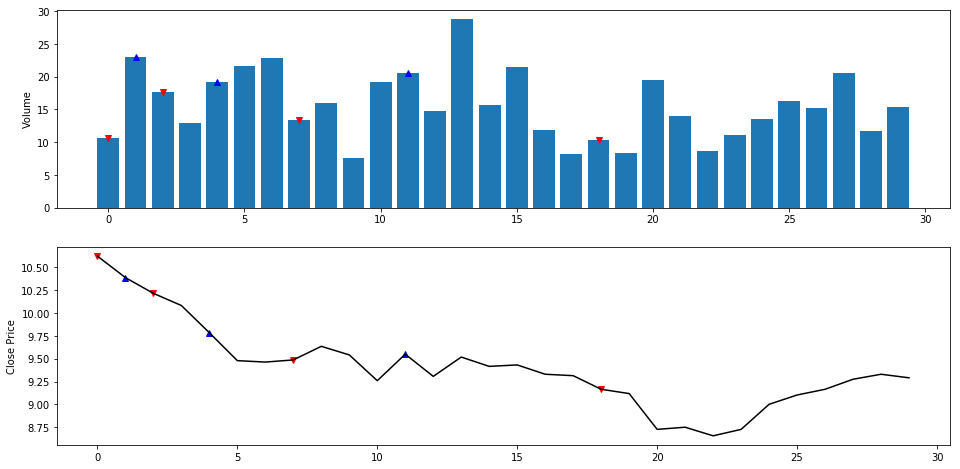

In [104]:
evals = evaluation(model_name='resnet_18.1512600792.h5', stock_name='000333.SZ')
show_plot(evals)